In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import seaborn as sns
import os

In [4]:
# Load and prepare data
df = pd.read_csv('sales_data_sample.csv', encoding='iso-8859-1')
df = df.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'})
df['ds'] = pd.to_datetime(df['ds'], format='mixed')
df = df.sort_values('ds')

05:25:37 - cmdstanpy - INFO - Chain [1] start processing
05:25:38 - cmdstanpy - INFO - Chain [1] done processing



Forecast Accuracy:
MAE: 1759.34
RMSE: 2187.06


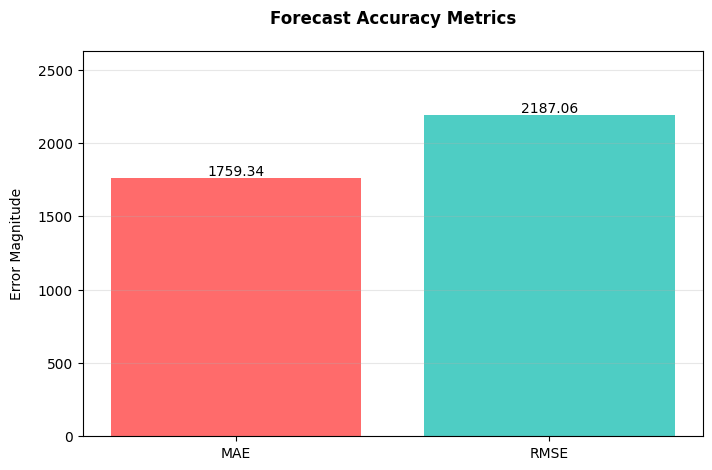

In [5]:
# Train/test split (last 90 days for test)
train_df = df[:-90]
test_df = df[-90:]

# Train Prophet model
model = Prophet()
model.fit(train_df)

# Make future dataframe (length of test period)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Merge forecast with actual test data
forecast_filtered = forecast[['ds', 'yhat']].set_index('ds')
test_df = test_df.set_index('ds')
comparison = test_df.join(forecast_filtered, how='left')

# Accuracy metrics
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
print("\nForecast Accuracy:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

metrics = {'MAE': mae, 'RMSE': rmse}
colors = ['#FF6B6B', '#4ECDC4']

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')

plt.title('Forecast Accuracy Metrics', pad=20, fontweight='bold')
plt.ylabel('Error Magnitude', labelpad=10)
plt.ylim(0, max(metrics.values()) * 1.2)
plt.grid(axis='y', alpha=0.3)
plt.show()


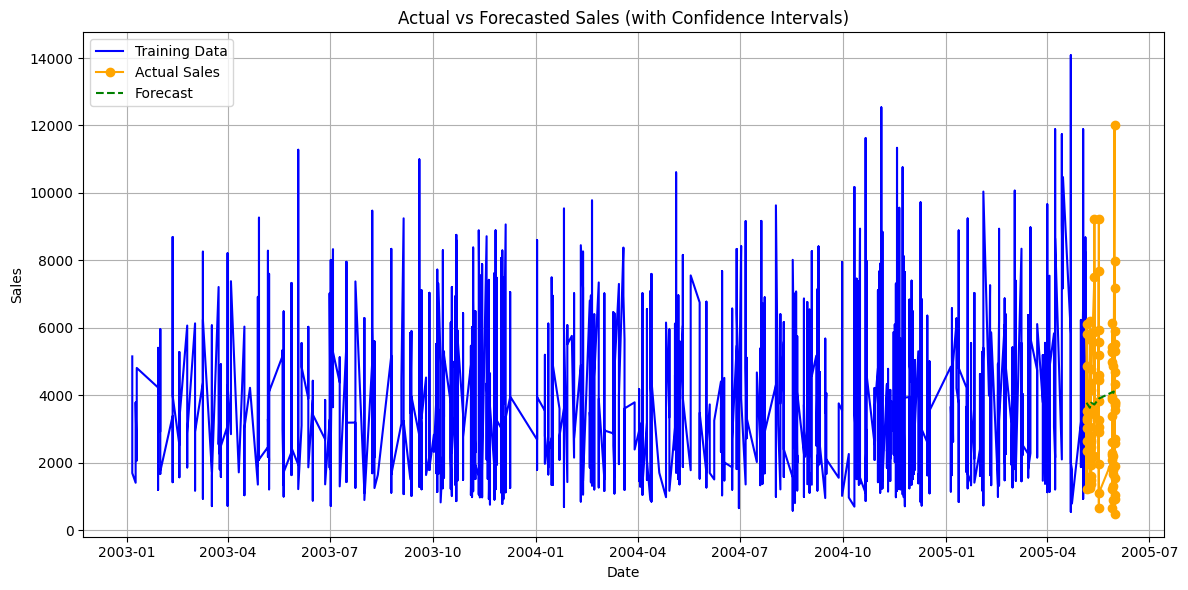

In [9]:
# Plot ACTUAL vs FORECAST
plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')
plt.plot(comparison.index, comparison['y'], label='Actual Sales', color='orange', marker='o')
plt.plot(comparison.index, comparison['yhat'], label='Forecast', linestyle='--', color='green')
plt.title('Actual vs Forecasted Sales (with Confidence Intervals)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


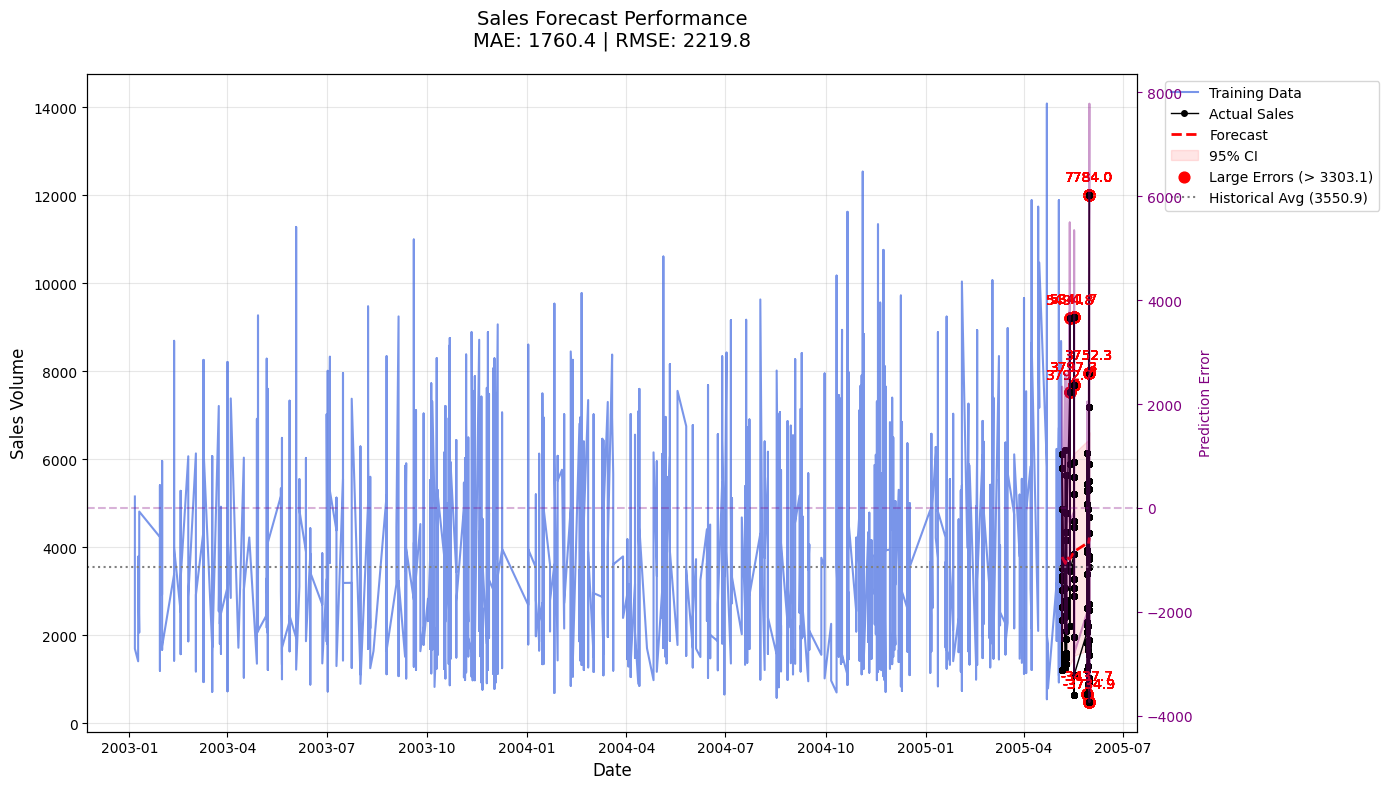

In [11]:
# Sales Forecast Performance
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# Create the visualization
plt.figure(figsize=(14, 8))

plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='royalblue', alpha=0.7)
plt.plot(comparison.index, comparison['y'], 'ko-', label='Actual Sales', markersize=4, linewidth=1)
plt.plot(comparison.index, comparison['yhat'], 'r--', label='Forecast', linewidth=2)

if 'yhat_lower' not in comparison.columns or 'yhat_upper' not in comparison.columns:
    forecast_ci = forecast.set_index('ds').loc[comparison.index][['yhat_lower', 'yhat_upper']]
    comparison = comparison.join(forecast_ci, how='left')

plt.fill_between(comparison.index, comparison['yhat_lower'],comparison['yhat_upper'], color='red', alpha=0.1, label='95% CI')

# Highlight large errors
errors = comparison['y'] - comparison['yhat']
large_error_threshold = 1.5 * errors.std()
large_errors = comparison[abs(errors) > large_error_threshold]

plt.scatter(large_errors.index, large_errors['y'], color='red', s=60, label=f'Large Errors (> {large_error_threshold:.1f})')

# Add error annotations
for idx, row in large_errors.iterrows():
    error = row['y'] - row['yhat']
    plt.annotate(f'{error:.1f}',
                (idx, row['y']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                color='red')

# Add reference lines
avg_sales = train_df['y'].mean()
plt.axhline(avg_sales, color='gray', linestyle=':', label=f'Historical Avg ({avg_sales:.1f})')

# Final formatting
plt.title(f'Sales Forecast Performance\nMAE: {mae:.1f} | RMSE: {rmse:.1f}', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add error plot on secondary axis
ax2 = plt.gca().twinx()
ax2.plot(comparison.index, errors,
        color='purple', alpha=0.4, label='Errors')
ax2.axhline(0, color='purple', linestyle='--', alpha=0.3)
ax2.set_ylabel('Prediction Error', color='purple')
ax2.tick_params(axis='y', colors='purple')

plt.tight_layout()
plt.show()


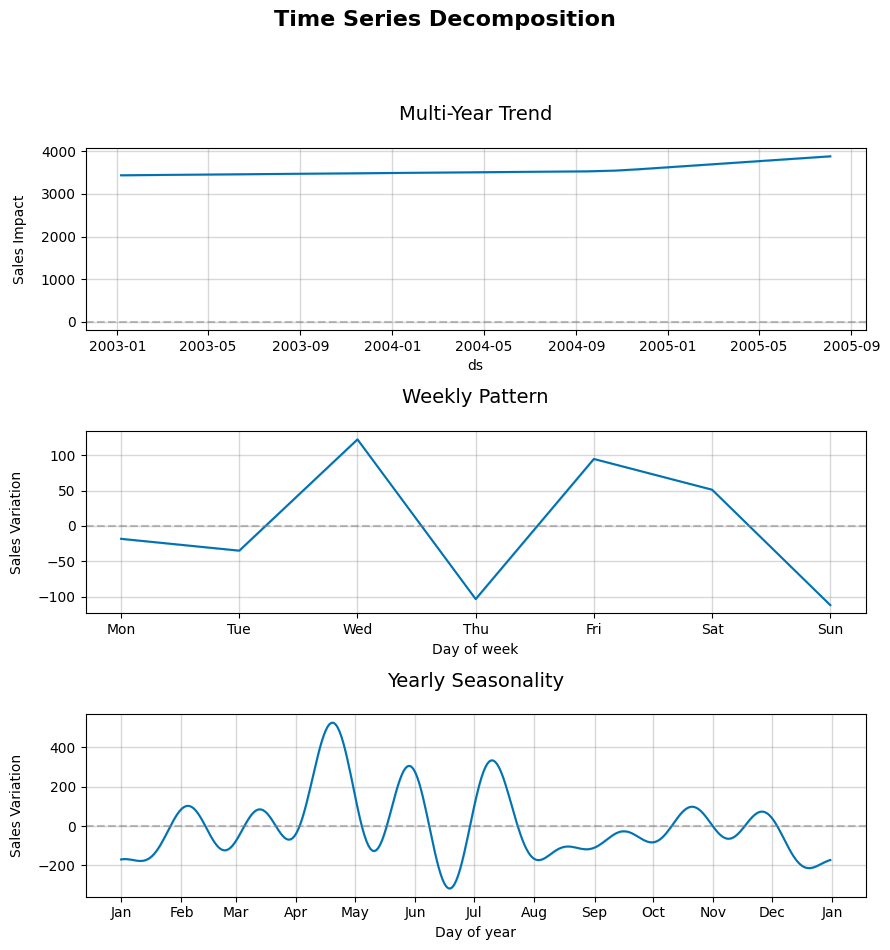

In [12]:
# Plot TREND + SEASONALITY
fig = model.plot_components(forecast)
axs = fig.axes

plt.suptitle('Time Series Decomposition', y=1.05, fontsize=16, fontweight='bold')

# 1. Trend Component
axs[0].set_title('Multi-Year Trend', pad=20, fontsize=14)
axs[0].set_ylabel('Sales Impact', labelpad=10)
axs[0].grid(True, alpha=0.3)
axs[0].axhline(0, color='gray', linestyle='--', alpha=0.5)

# 2. Weekly Seasonality
axs[1].set_title('Weekly Pattern', pad=20, fontsize=14)
axs[1].set_ylabel('Sales Variation', labelpad=10)
axs[1].grid(True, alpha=0.3)
axs[1].axhline(0, color='gray', linestyle='--', alpha=0.5)

# Custom x-axis labels for weekly plot
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(weekday_labels)

# 3. Yearly Seasonality (if present)
if len(axs) > 2:
    axs[2].set_title('Yearly Seasonality', pad=20, fontsize=14)
    axs[2].set_ylabel('Sales Variation', labelpad=10)
    axs[2].grid(True, alpha=0.3)
    axs[2].axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Format x-axis as month names
    import matplotlib.dates as mdates
    axs[2].xaxis.set_major_locator(mdates.MonthLocator())
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

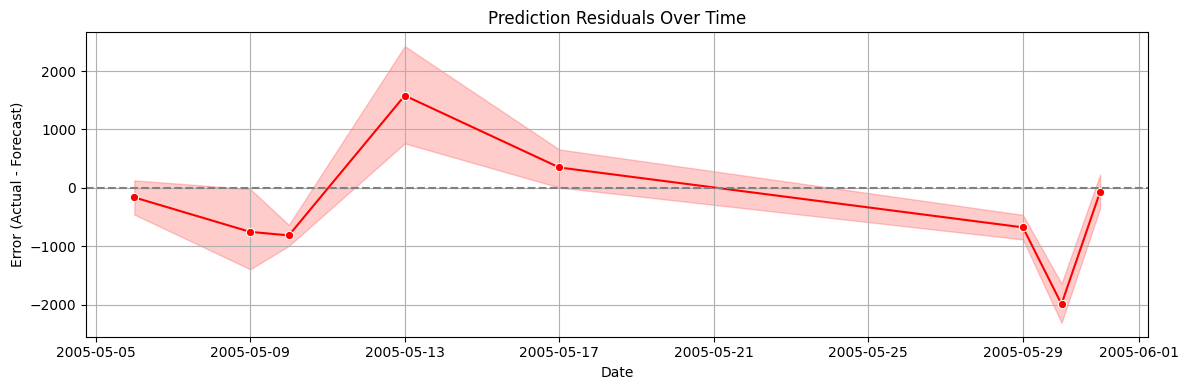

In [13]:
# Plot RESIDUALS
comparison['residual'] = comparison['y'] - comparison['yhat']
plt.figure(figsize=(12, 4))
sns.lineplot(data=comparison, x=comparison.index, y='residual', marker='o', color='red')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Prediction Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Error (Actual - Forecast)')
plt.grid(True)
plt.tight_layout()
plt.show()

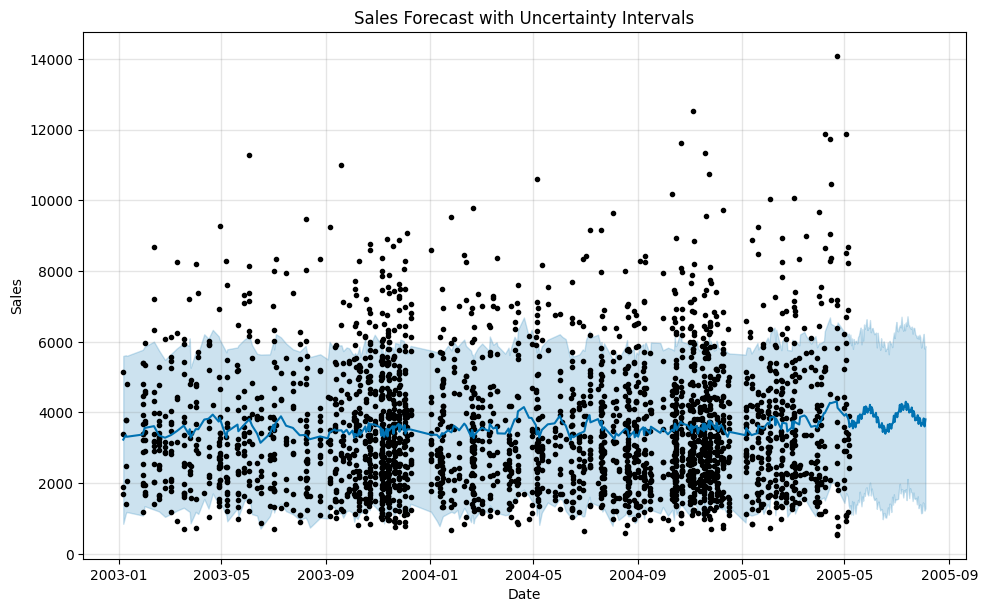

In [14]:
# Plot forecast
fig2 = model.plot(forecast)
plt.title('Sales Forecast with Uncertainty Intervals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

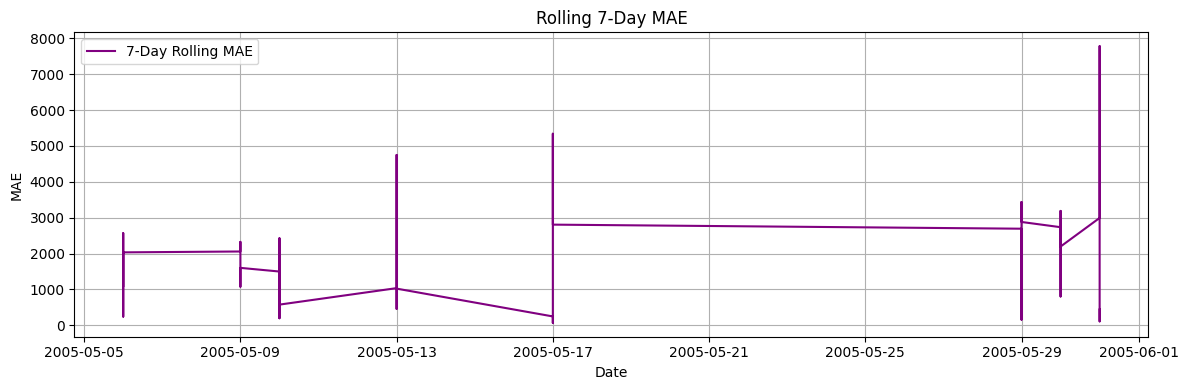

In [15]:
# Rolling MAE Plot
window = 7
comparison['abs_error'] = abs(comparison['y'] - comparison['yhat'])
rolling_mae = comparison['abs_error'].rolling(window=window).mean()

plt.figure(figsize=(12, 4))
plt.plot(rolling_mae, label=f'{window}-Day Rolling MAE', color='purple')
plt.title(f'Rolling {window}-Day MAE')
plt.xlabel('Date')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


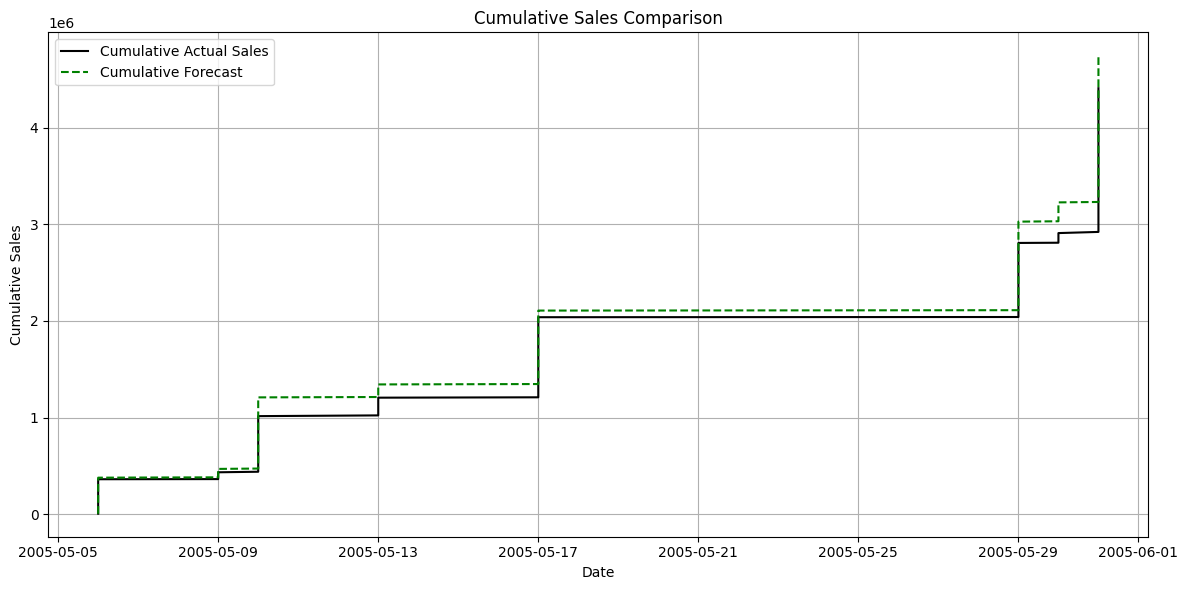

In [16]:
#Cumulative Actual vs Forecast
comparison['actual_cumsum'] = comparison['y'].cumsum()
comparison['forecast_cumsum'] = comparison['yhat'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(comparison.index, comparison['actual_cumsum'], label='Cumulative Actual Sales', color='black')
plt.plot(comparison.index, comparison['forecast_cumsum'], label='Cumulative Forecast', linestyle='--', color='green')
plt.title('Cumulative Sales Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


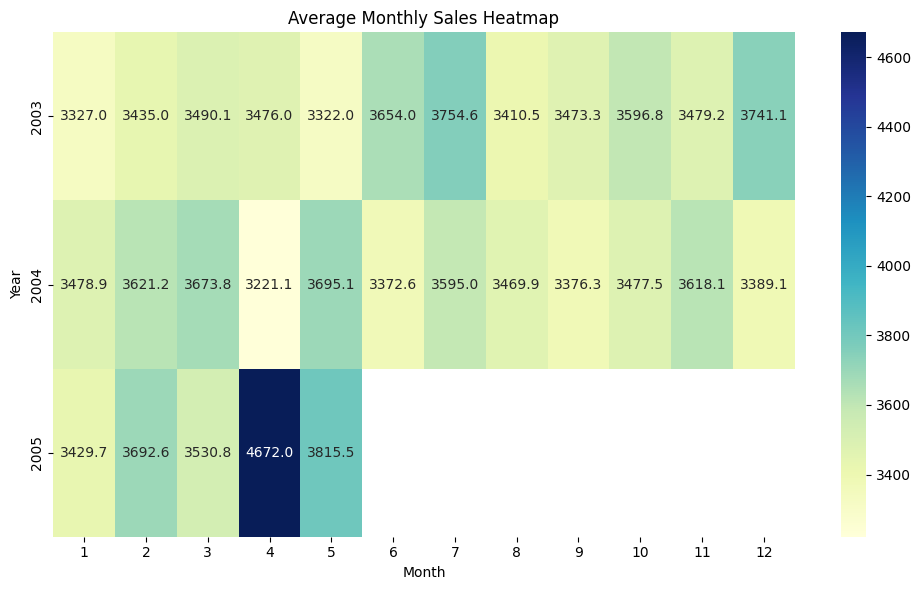

In [17]:
# Sales Heatmap (Monthly)
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
monthly_avg = df.groupby(['year', 'month'])['y'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(monthly_avg, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Average Monthly Sales Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


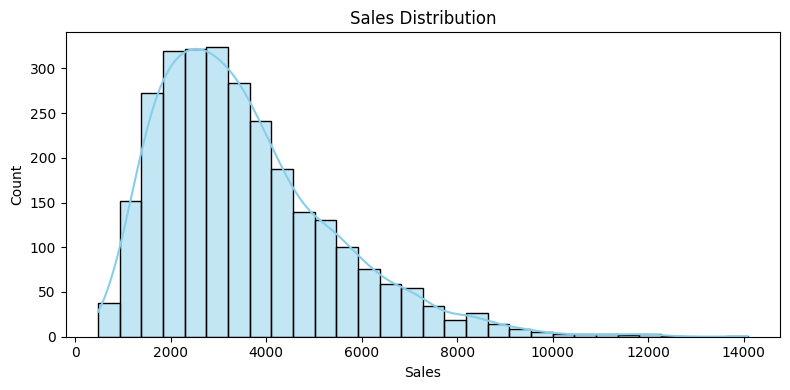

In [18]:
# Sales Distribution Histogram
plt.figure(figsize=(8, 4))
sns.histplot(df['y'], bins=30, kde=True, color='skyblue')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.tight_layout()
plt.show()


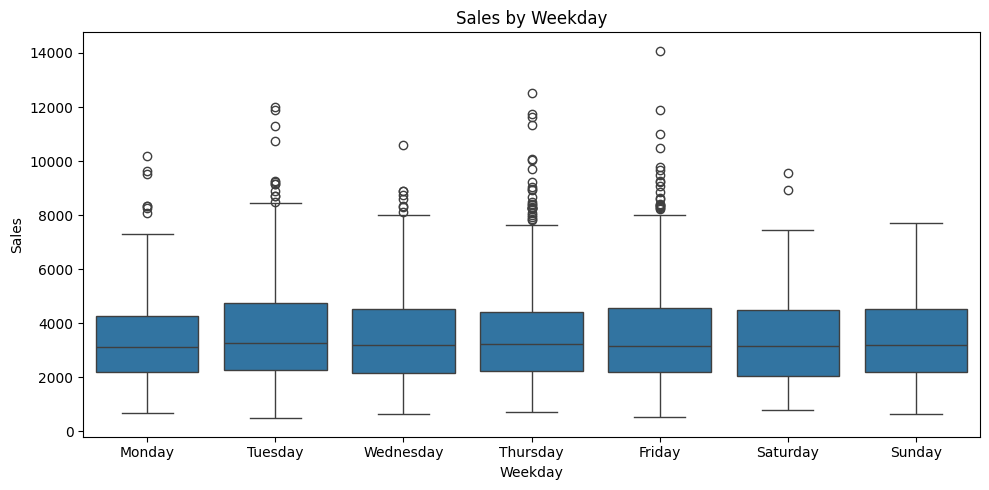

In [19]:
# Boxplot by Weekday
df['weekday'] = df['ds'].dt.day_name()
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday', y='y', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Sales by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


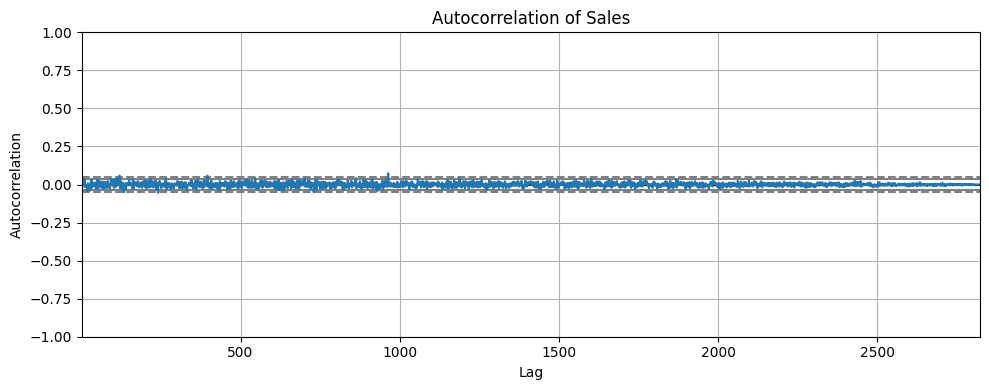

In [20]:
# Autocorrelation Plot
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 4))
autocorrelation_plot(df['y'])
plt.title('Autocorrelation of Sales')
plt.tight_layout()
plt.show()


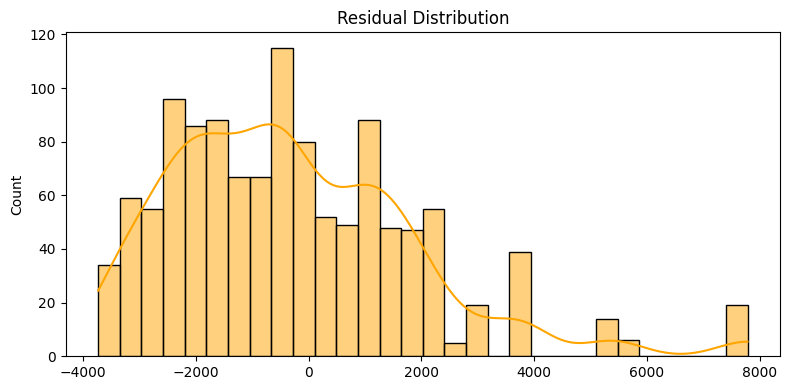

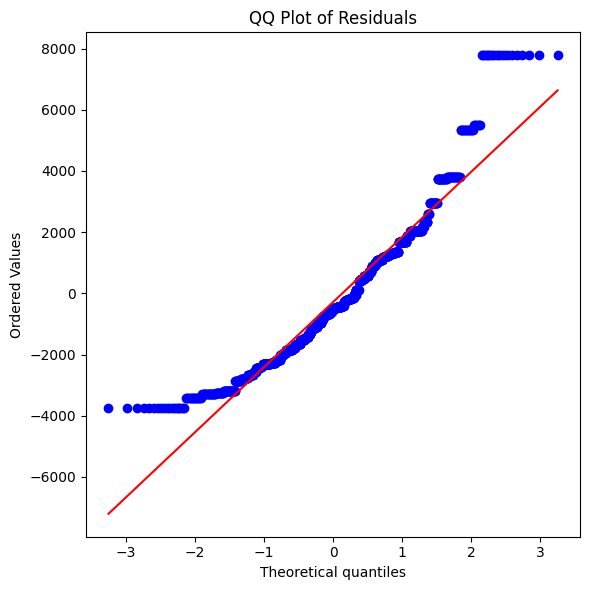

In [21]:
# Residual Distribution & QQ Plot
import scipy.stats as stats

residuals = comparison['y'] - comparison['yhat']

# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

# QQ Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals.dropna(), dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.tight_layout()
plt.show()


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/16 [00:00<?, ?it/s]05:37:50 - cmdstanpy - INFO - Chain [1] start processing
05:37:50 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:02,  7.13it/s]05:37:50 - cmdstanpy - INFO - Chain [1] start processing
05:37:50 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  6.85it/s]05:37:50 - cmdstanpy - INFO - Chain [1] start processing
05:37:50 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:02,  6.38it/s]05:37:50 - cmdstanpy - INFO - Chain [1] start processing
05:37:50 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:01,  6.43it/s]05:37:50 - cmdstanpy - INFO - Chain [1] start processing
05:37:50 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:00<00:01,  6.53it/s]05:37:51 - cmdstanpy - INFO - Chain [1] start processing
05:37:

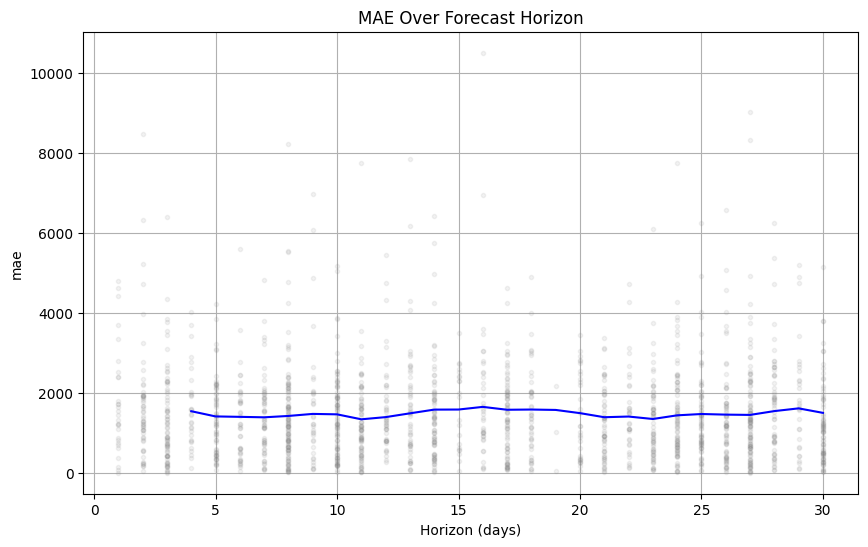

In [22]:
# MAE Over Forecast Horizon
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='30 days')
plot_cross_validation_metric(df_cv, metric='mae')
plt.title("MAE Over Forecast Horizon")
plt.show()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/16 [00:00<?, ?it/s]05:37:55 - cmdstanpy - INFO - Chain [1] start processing
05:37:55 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:02,  6.80it/s]05:37:55 - cmdstanpy - INFO - Chain [1] start processing
05:37:55 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  6.72it/s]05:37:56 - cmdstanpy - INFO - Chain [1] start processing
05:37:56 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:01,  6.62it/s]05:37:56 - cmdstanpy - INFO - Chain [1] start processing
05:37:56 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [00:00<00:01,  6.67it/s]05:37:56 - cmdstanpy - INFO - Chain [1] start processing
05:37:56 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [00:00<00:01,  6.50it/s]05:37:56 - cmdstanpy - INFO - Chain [1] start processing
05:37:

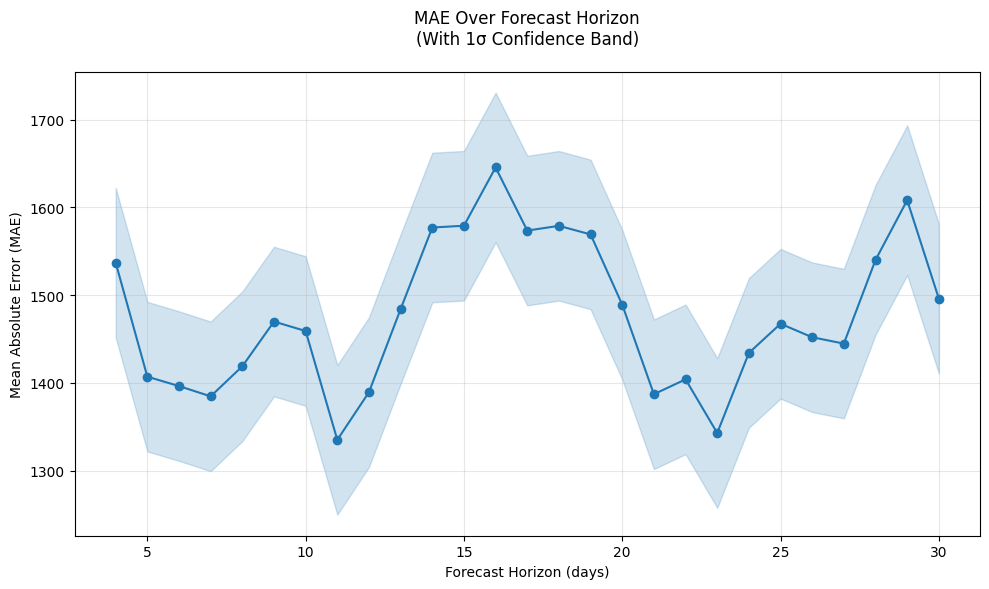

In [23]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
df_cv = cross_validation(
    model,
    initial='365 days',
    period='30 days',
    horizon='30 days'
)

# Calculate metrics
df_p = performance_metrics(df_cv)

# Custom plot
plt.figure(figsize=(10, 6))
plt.plot(df_p['horizon'].dt.days, df_p['mae'], 
         marker='o', linestyle='-', color='#1f77b4')
plt.fill_between(
    df_p['horizon'].dt.days,
    df_p['mae'] - df_p['mae'].std(),
    df_p['mae'] + df_p['mae'].std(),
    color='#1f77b4',
    alpha=0.2
)

plt.title('MAE Over Forecast Horizon\n(With 1σ Confidence Band)', pad=20)
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

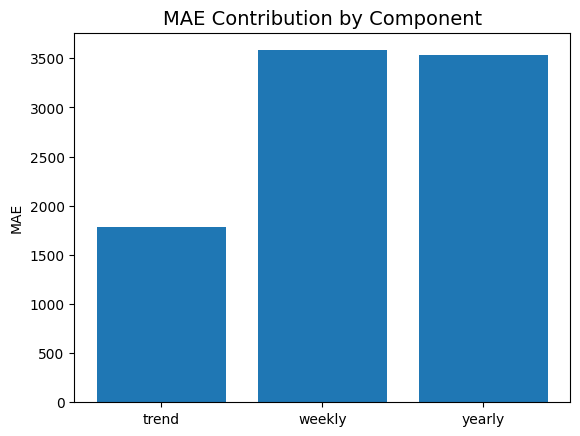

In [24]:
# Decompose forecast into components
components = forecast.set_index('ds')[['trend', 'weekly', 'yearly']].iloc[-len(test_df):]

# Calculate component-wise contribution to error
component_errors = {}
for col in components.columns:
    component_errors[col] = np.mean(np.abs(test_df['y'] - components[col]))

plt.bar(component_errors.keys(), component_errors.values())
plt.title("MAE Contribution by Component", fontsize=14)
plt.ylabel("MAE")
plt.show()